In [6]:
# ============================= PATH SETUP =============================
# Choose ONE of the following blocks depending on where you run the notebook.
# ------------------------------------------------------------------------------

from pathlib import Path
import sys

# ------------------------------------------------------------------------------
# OPTION A — Google Colab
# ------------------------------------------------------------------------------
# If you are running on Google Colab, UNCOMMENT this block.

"""
from google.colab import drive
drive.mount("/content/drive")

ROOT = Path("/content/drive/MyDrive/mbrl-testing-frameworks-empirical-study")

"""
# ------------------------------------------------------------------------------
# OPTION B — Local machine (GitHub clone)
# ------------------------------------------------------------------------------
# If you are running locally (e.g., after `git clone`), UNCOMMENT this block.
"""
ROOT = Path("mbrl-testing-frameworks-empirical-study")
"""
# ------------------------------------------------------------------------------
# Shared paths (DO NOT EDIT BELOW)
# ------------------------------------------------------------------------------

AGENT_ROOT  = ROOT / "agents" / "pets" / "pendulum/pets_pendulum_base"
RESULTS_DIR = ROOT / "results" / "pendulum"
TABLES_DIR  = RESULTS_DIR / "tables"
FIGS_DIR    = RESULTS_DIR / "figs"
RAW_DIR     = RESULTS_DIR / "raw_single"

RESULTS_DIR.mkdir(parents=True, exist_ok=True)
TABLES_DIR.mkdir(parents=True, exist_ok=True)
FIGS_DIR.mkdir(parents=True, exist_ok=True)
RAW_DIR.mkdir(parents=True, exist_ok=True)

if str(AGENT_ROOT) not in sys.path:
    sys.path.insert(0, str(AGENT_ROOT))

print("AGENT_ROOT :", AGENT_ROOT)
print("RESULTS_DIR:", RESULTS_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
AGENT_ROOT : /content/drive/MyDrive/mbrl-testing-frameworks-empirical-study/agents/pets/pendulum/pets_pendulum_base
RESULTS_DIR: /content/drive/MyDrive/mbrl-testing-frameworks-empirical-study/results/pendulum


In [ ]:
import os
import json
import random
import numpy as np

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

Mounted at /content/drive
AGENT_ROOT : /content/drive/MyDrive/mbrl-testing-frameworks-empirical-study/agents/pets/pendulum/pets_pendulum_base
RESULTS_DIR: /content/drive/MyDrive/mbrl-testing-frameworks-empirical-study/results/pendulum


In [7]:
# PETS Pendulum agent loading + rollout (testing only)
# =========================================================

import os, json, time
import numpy as np
import torch
import torch.nn as nn
import gymnasium as gym
from dataclasses import dataclass


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Agent bundle
# -------------------------
AGENT_DIR = AGENT_ROOT
CKPT_DIR  = AGENT_DIR / "checkpoint"

assert AGENT_DIR.is_dir(), "Agent bundle not found"
assert CKPT_DIR.is_dir(), "Checkpoint directory not found"

# Load config
# -------------------------
with open(AGENT_DIR / "config.json", "r") as f:
    config_json = json.load(f)

obs_dim  = config_json["obs_dim"]
act_dim  = config_json["act_dim"]
act_low  = config_json["action_low"]
act_high = config_json["action_high"]

# PETS configuration
# -------------------------
@dataclass
class PETSConfig:
    ensemble_size: int = 5
    hidden_dim: int = 128
    horizon: int = 20
    pop_size: int = 400
    elite_frac: float = 0.2
    num_iters: int = 4
    action_low: float = -2.0
    action_high: float = 2.0
    init_std: float = 1.0

pets_cfg = PETSConfig(**config_json["pets_cfg"])

# Environment helpers
# -------------------------
def make_env(seed=None):
    env = gym.make("Pendulum-v1")
    if seed is not None:
        env.reset(seed=seed)
    return env

def reset_env(env, seed=None):
    obs, _ = env.reset(seed=seed) if seed is not None else env.reset()
    return obs

def step_env(env, action):
    obs, rew, terminated, truncated, info = env.step(action)
    done = bool(terminated or truncated)
    return obs, float(rew), done, info


# Reward (same as training)
# -------------------------
def pendulum_reward(state, action):
    cos_th, sin_th, thdot = state[..., 0], state[..., 1], state[..., 2]
    theta = torch.atan2(sin_th, cos_th)
    cost = theta**2 + 0.1 * thdot**2 + 0.001 * (action[..., 0]**2)
    return -cost

# Dynamics model
# -------------------------
class DynamicsNet(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, x):
        return self.net(x)

class EnsembleDynamics(nn.Module):
    def __init__(self, in_dim, out_dim, ensemble_size, hidden_dim):
        super().__init__()
        self.ensemble_size = ensemble_size
        self.models = nn.ModuleList([
            DynamicsNet(in_dim, out_dim, hidden_dim)
            for _ in range(ensemble_size)
        ])

    def predict_delta(self, x, model_idx):
        return self.models[model_idx](x)

# PETS controller
# -------------------------
class PETSController:
    def __init__(self, model, cfg, obs_dim, act_dim):
        self.model = model
        self.cfg = cfg
        self.obs_dim = obs_dim
        self.act_dim = act_dim

    def plan(self, obs_np):
        cfg = self.cfg
        horizon = cfg.horizon
        pop_size = cfg.pop_size
        elite_size = int(pop_size * cfg.elite_frac)

        mean = np.zeros((horizon, self.act_dim), dtype=np.float32)
        std  = np.ones((horizon, self.act_dim), dtype=np.float32) * cfg.init_std

        obs_t = torch.from_numpy(obs_np).float().to(device)
        self.model.eval()

        with torch.no_grad():
            for _ in range(cfg.num_iters):
                actions = np.random.normal(mean, std, size=(pop_size, horizon, self.act_dim))
                actions = np.clip(actions, cfg.action_low, cfg.action_high)

                returns = self._evaluate(obs_t, actions)
                elite = actions[np.argsort(returns)[-elite_size:]]
                mean = elite.mean(axis=0)
                std  = elite.std(axis=0) + 1e-6

        return np.clip(mean[0], cfg.action_low, cfg.action_high).astype(np.float32)

    def _evaluate(self, obs_t, actions_np):
        pop_size, horizon, _ = actions_np.shape
        returns = np.zeros(pop_size, dtype=np.float32)

        model_idx = np.random.randint(self.model.ensemble_size)
        states = obs_t.unsqueeze(0).repeat(pop_size, 1)

        with torch.no_grad():
            for t in range(horizon):
                act_t = torch.from_numpy(actions_np[:, t]).float().to(device)
                x = torch.cat([states, act_t], dim=-1)
                delta = self.model.predict_delta(x, model_idx)
                states = states + delta
                r = pendulum_reward(states, act_t)
                returns += r.cpu().numpy()

        return returns

# Load ensemble checkpoint
# -------------------------
ckpt = torch.load(CKPT_DIR / "ensemble.pt", map_location=device)

model = EnsembleDynamics(
    ckpt["in_dim"],
    ckpt["out_dim"],
    ckpt["ensemble_size"],
    ckpt["hidden_dim"],
).to(device)

for m, sd in zip(model.models, ckpt["state_dicts"]):
    m.load_state_dict(sd)

model.eval()
controller = PETSController(model, pets_cfg, obs_dim, act_dim)

# Rollout (single episode)
# -------------------------
PEND_MAX_STEPS = config_json["training"]["episode_len"]
R_FAIL_PEND    = -300.0

def pendulum_rollout(seed=None):
    env = make_env(seed)
    obs = reset_env(env, seed)
    cum, steps = 0.0, 0
    t0 = time.time()

    while True:
        act = controller.plan(obs)
        obs, r, done, _ = step_env(env, act)
        cum += r
        steps += 1
        if done or steps >= PEND_MAX_STEPS:
            break

    env.close()
    return {
        "return":  float(cum),
        "steps":   int(steps),
        "failure": int(cum <= R_FAIL_PEND),
        "wall_dt": float(time.time() - t0),
    }

In [ ]:
# Unified test settings, metrics, and paths (single-run)
# =========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Paths
# -------------------------
RAW_DIR = RESULTS_DIR / "raw_single"
RAW_DIR.mkdir(exist_ok=True)

# Budget & seeds
# -------------------------
EPISODE_BUDGET = 500
SEED_BASE = 2025   # kept for reproducibility parity (not iterated)

# Framework color palette
# -------------------------
FRAMEWORK_COLORS = {
    "AdaStop":"#808000",
    "F-Oracle":"#000080",
    "CUSUM-RL":"#DDA0DD",
    "DLBT":"#008000",
    "MDPMorph":"#B56576",
    "QD-Testing":"#580F41",
    "STARLA":"#069AF3",
    "Indago":"#40E0D0",
    "AlphaTest":"#9A0EEA",
    "NR-RL":"#9ACD32",
    "SBF":"#FE420F",
    "MDPFuzz":"#EE82EE",
    "pi-Fuzz":"#808080",
    "GMBT":"#C79FEF",
    "CureFuzz":"#E50000",
    "RLMutation":"#15B01A",
    "FS":"#DAA520",
    "μPRL":"#3357A6",
}

def fw_color(name):
    return FRAMEWORK_COLORS.get(name, "#777777")

# Metrics
# -------------------------
def compute_FR(fails):
    a = np.asarray(fails, dtype=np.int32)
    return float(a.mean()) if len(a) else np.nan

def compute_TTF_tests(fails):
    for i, f in enumerate(fails, start=1):
        if int(f) == 1:
            return float(i)
    return float(len(fails)) if len(fails) else np.nan

def compute_TTF_seconds(fails, times):
    if not fails:
        return np.nan
    c = np.cumsum(times)
    for i, f in enumerate(fails):
        if int(f) == 1:
            return float(c[i])
    return float(c[-1])

def compute_total_seconds(times):
    t = np.asarray(times, dtype=np.float64)
    return float(t.sum()) if t.size else np.nan

# Raw saving & summarization
# -------------------------
def _save_raw(framework, rows):
    df = pd.DataFrame(rows)
    path = RAW_DIR / f"{framework}_episodes.csv"
    df.to_csv(path, index=False)
    return str(path)

def summarize_framework(framework, rows):
    fails = [int(r.get("failure", 0)) for r in rows]
    times = [float(r.get("wall_dt", 0.0)) for r in rows]
    return {
        "framework": framework,
        "FR": compute_FR(fails),
        "TTF_tests": compute_TTF_tests(fails),
        "TTF_seconds": compute_TTF_seconds(fails, times),
        "total_seconds": compute_total_seconds(times),
        "budget": len(fails),
    }

# Base test primitive
# -------------------------
def pendulum_test():
    return pendulum_rollout()

In [ ]:
# Framework definitions & registration (single-run, Pendulum)
# =========================================================
from scipy.stats import permutation_test

# Base execution (policy-agnostic)
# -------------------------
def run_base_execution(budget=EPISODE_BUDGET):
    return [pendulum_test() for _ in range(budget)]

# Threshold-based frameworks
# -------------------------
def run_MDPFuzz_single(budget=EPISODE_BUDGET):
    rows = []
    for _ in range(budget):
        r = pendulum_test()
        if r["return"] <= R_FAIL_PEND and r["steps"] > 0.8 * PEND_MAX_STEPS:
            r = dict(r); r["failure"] = 1
        rows.append(r)
    return rows

def run_FS_single(budget=EPISODE_BUDGET):
    thr = R_FAIL_PEND + 50.0
    rows = []
    for _ in range(budget):
        r = pendulum_test()
        if r["return"] <= thr:
            r = dict(r); r["failure"] = 1
        rows.append(r)
    return rows

def run_RLMutation_single(budget=EPISODE_BUDGET):
    thr = R_FAIL_PEND - 100.0
    rows = []
    for _ in range(budget):
        r = pendulum_test()
        if r["return"] <= thr:
            r = dict(r); r["failure"] = 1
        rows.append(r)
    return rows

def run_MUPRL_single(budget=EPISODE_BUDGET):
    rows = []
    for i in range(budget):
        r = pendulum_test()
        if (i % 15 == 0) and (r["return"] <= R_FAIL_PEND + 50.0):
            r = dict(r); r["failure"] = 1
        rows.append(r)
    return rows

# Metamorphic testing
# -------------------------
def _mr_small_perturbation_same_outcome():
    rA = pendulum_test()
    rB = pendulum_test()
    violated = int((rA["failure"] == 0) != (rB["failure"] == 0))
    return {
        "return": 0.5 * (rA["return"] + rB["return"]),
        "steps": int(0.5 * (rA["steps"] + rB["steps"])),
        "failure": violated,
        "wall_dt": 0.5 * (rA["wall_dt"] + rB["wall_dt"]),
    }

def run_MDPMorph_single(budget=EPISODE_BUDGET):
    return [_mr_small_perturbation_same_outcome() for _ in range(budget)]

# Statistical / oracle-based frameworks
# -------------------------
def _perm_pvalue(x, y, reps=500):
    res = permutation_test(
        (np.asarray(x), np.asarray(y)),
        statistic=lambda a, b: np.mean(a) - np.mean(b),
        permutation_type="independent",
        n_resamples=reps,
        alternative="two-sided",
    )
    return float(res.pvalue)

def run_AdaStop_single(budget=EPISODE_BUDGET, interims=6, block=3, alpha=0.05):
    x, y = [], []
    q = [alpha / interims] * interims
    rejects = []

    for k in range(interims):
        for _ in range(block):
            x.append(pendulum_test()["return"])
            y.append(pendulum_test()["return"])
        p = _perm_pvalue(x, y)
        rejects.append(int(p < q[k]))
        if p < q[k]:
            break

    fails = [0] * budget
    if any(rejects):
        pos = max(1, int((rejects.index(1) + 1) * budget / interims))
        fails[pos - 1] = 1

    return [{"failure": f, "steps": 1, "wall_dt": 0.0} for f in fails]

def run_FOracle_single(budget=EPISODE_BUDGET, epochs=20):
    comps = []
    for _ in range(epochs):
        comps.append(pendulum_test()["return"] / 200.0)

    slope = np.polyfit(np.arange(len(comps)), comps, 1)[0]
    fails = [0] * budget
    if slope < 0:
        fails[0] = 1

    return [{"failure": f, "steps": 1, "wall_dt": 0.0} for f in fails]

def run_CUSUMRL_single(budget=EPISODE_BUDGET):
    scores = [pendulum_test()["return"] for _ in range(40)]
    p = _perm_pvalue(scores[:20], scores[20:])
    fails = [0] * budget
    if p < 0.05:
        fails[int(0.2 * budget) - 1] = 1
    return [{"failure": f, "steps": 1, "wall_dt": 0.0} for f in fails]

# Registration
# -------------------------
FRAMEWORK_RUNNERS = {
    "AdaStop": run_AdaStop_single,
    "F-Oracle": run_FOracle_single,
    "CUSUM-RL": run_CUSUMRL_single,
    "MDPMorph": run_MDPMorph_single,
    "MDPFuzz": run_MDPFuzz_single,
    "FS": run_FS_single,
    "RLMutation": run_RLMutation_single,
    "μPRL": run_MUPRL_single,
}

ALL_FRAMEWORKS = [
    "AdaStop", "F-Oracle", "CUSUM-RL", "DLBT", "MDPMorph",
    "QD-Testing", "STARLA", "Indago", "AlphaTest",
    "NR-RL", "SBF", "MDPFuzz", "pi-Fuzz", "GMBT",
    "CureFuzz", "RLMutation", "FS", "μPRL",
]

POLICY_AGNOSTIC_FRAMEWORKS = sorted(
    set(ALL_FRAMEWORKS) - set(FRAMEWORK_RUNNERS.keys())
)

In [ ]:
# Execute single-run benchmark (18 frameworks, PETS+Pendulum)
# =========================================================

rows = []

for fw in ALL_FRAMEWORKS:
    print(f"→ Running {fw}")

    try:
        if fw in FRAMEWORK_RUNNERS:
            ep_rows = FRAMEWORK_RUNNERS[fw](EPISODE_BUDGET)
        elif fw in POLICY_AGNOSTIC_FRAMEWORKS:
            ep_rows = run_base_execution(EPISODE_BUDGET)
        else:
            raise ValueError(f"Framework not registered: {fw}")

        raw_path = _save_raw(fw, ep_rows)
        summary = summarize_framework(fw, ep_rows)
        summary["raw_path"] = raw_path
        rows.append(summary)

    except Exception as e:
        print("  !! error:", e)
        rows.append({
            "framework": fw,
            "FR": np.nan,
            "TTF_tests": np.nan,
            "TTF_seconds": np.nan,
            "total_seconds": np.nan,
            "budget": 0,
            "raw_path": "",
        })

SINGLE = pd.DataFrame(rows)
csv_path = TABLES_DIR / "pendulum_single_row_metrics.csv"
SINGLE.to_csv(csv_path, index=False)

print("Saved metrics table →", csv_path)
display(SINGLE.sort_values("framework"))

→ Running AdaStop
→ Running F-Oracle
→ Running CUSUM-RL
→ Running DLBT
→ Running MDPMorph
→ Running QD-Testing
→ Running STARLA
→ Running Indago
→ Running AlphaTest
→ Running NR-RL
→ Running SBF
→ Running MDPFuzz
→ Running pi-Fuzz
→ Running GMBT
→ Running CureFuzz
→ Running RLMutation


In [ ]:
# Single-run summary table (PETS + Pendulum)
# =========================================================

import pandas as pd

single_csv = TABLES_DIR / "pendulum_single_row_metrics.csv"
assert single_csv.exists(), f"Metrics table not found: {single_csv}"

SINGLE = pd.read_csv(single_csv)
SINGLE = SINGLE.sort_values("framework").reset_index(drop=True)

print("=== Single-run metrics (all 18 frameworks) ===")
display(SINGLE)

=== Single-run metrics (all 18 frameworks) ===


,framework,FR,TTF_tests,TTF_seconds,total_seconds,budget,raw_path
0,FS,0.280,8.0,64.429136,3987.510190,500,/content/drive/MyDrive/mbrl-testing-frameworks...
1,μPRL,0.242,1.0,7.946732,3998.804426,500,/content/drive/MyDrive/mbrl-testing-frameworks...


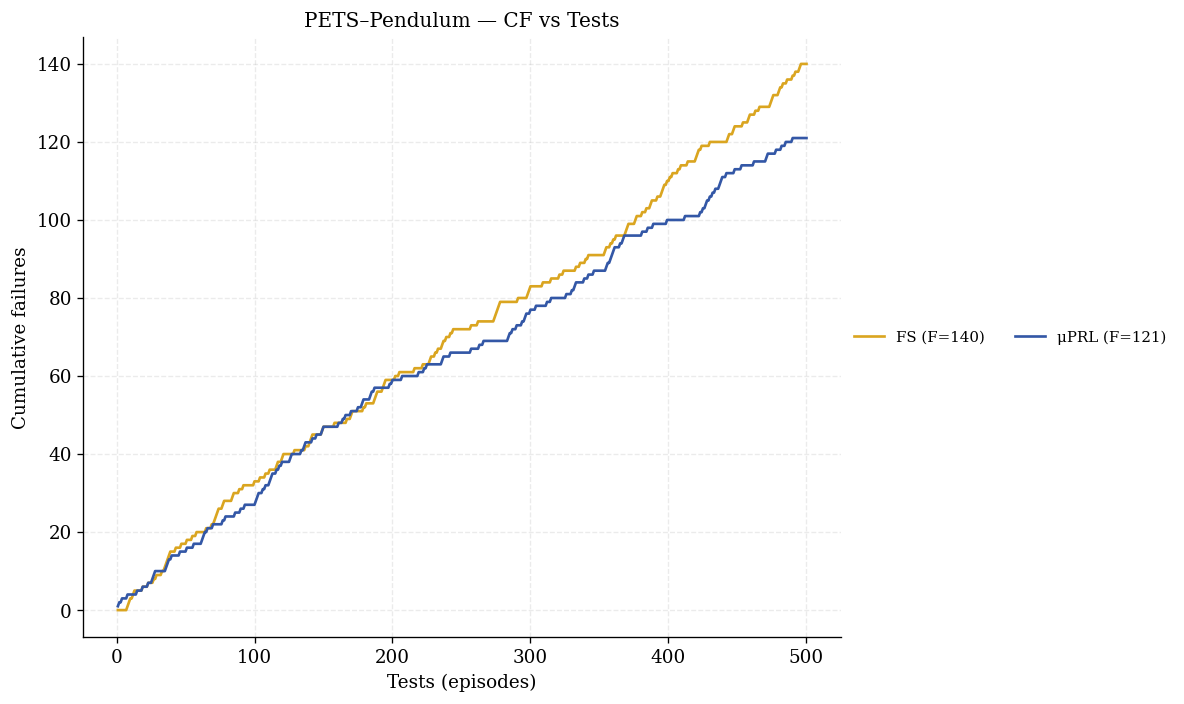

Saved: /content/drive/MyDrive/mbrl-testing-frameworks-empirical-study/results/pendulum/figs/cf/pendulum_cf_vs_tests


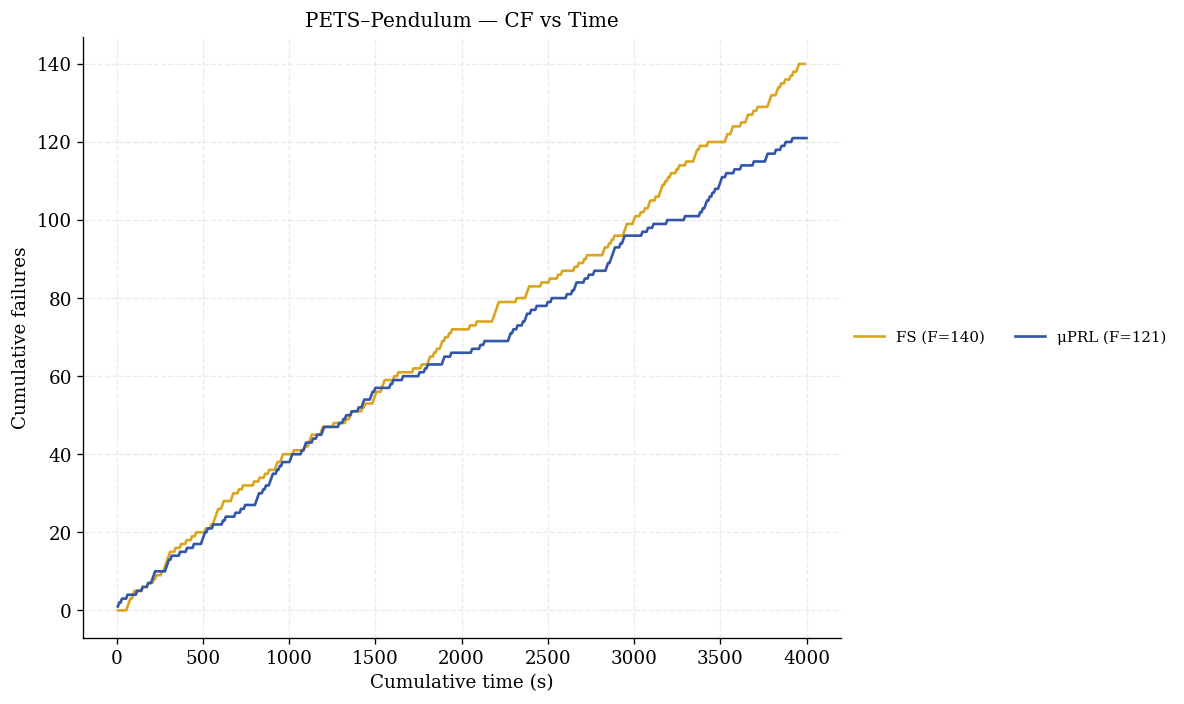

Saved: /content/drive/MyDrive/mbrl-testing-frameworks-empirical-study/results/pendulum/figs/cf/pendulum_cf_vs_time


In [ ]:
# CF vs Tests & CF vs Time (PETS + Pendulum, single-run)
# =========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RAW_DIR = RESULTS_DIR / "raw_single"
FIGS_DIR_CF = FIGS_DIR / "cf"
FIGS_DIR_CF.mkdir(exist_ok=True)

BUDGET = int(EPISODE_BUDGET)

# Unified color palette (unchanged)
# -------------------------
COL = FRAMEWORK_COLORS
def _col(name):
    return COL.get(name, "#777777")

#
# Helpers
# -------------------------
def _read_csv_auto(path):
    try:
        return pd.read_csv(path)
    except Exception:
        return None

def _canon(df, budget):
    if df is None or "failure" not in df.columns:
        return None
    d = df.copy()
    if "steps" not in d.columns:
        d["steps"] = 1
    d["failure"] = pd.to_numeric(d["failure"], errors="coerce").fillna(0).astype(int)
    d["steps"]   = pd.to_numeric(d["steps"], errors="coerce").fillna(1).astype(float)
    if "wall_dt" in d.columns:
        d["time_sec"] = pd.to_numeric(d["wall_dt"], errors="coerce").fillna(0.0)
    else:
        d["time_sec"] = d["steps"]

    if len(d) < budget:
        pad = pd.DataFrame({
            "failure": [0] * (budget - len(d)),
            "steps":   [d["steps"].median() or 1.0] * (budget - len(d)),
            "time_sec":[d["time_sec"].median() or 0.0] * (budget - len(d)),
        })
        d = pd.concat([d, pad], ignore_index=True)

    return d.iloc[:budget].reset_index(drop=True)

def _cum(df):
    y = np.maximum.accumulate(df["failure"].to_numpy().cumsum())
    t = df["time_sec"].to_numpy().cumsum()
    x = np.arange(1, len(df) + 1)
    return x, y, t

# Plot style (UNCHANGED)
# -------------------------
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "figure.dpi": 120,
    "savefig.dpi": 300,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "font.size": 11,
    "axes.labelsize": 11,
    "axes.titlesize": 12,
    "legend.fontsize": 9,
    "axes.linewidth": 0.8,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "grid.linestyle": "--",
    "lines.linewidth": 1.6,
    "legend.frameon": False,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# Plot
# -------------------------
for axis in ("tests", "time"):
    plt.figure()
    plotted = 0

    for fw in SINGLE["framework"]:
        raw_path = RAW_DIR / f"{fw}_episodes.csv"
        dfw = _canon(_read_csv_auto(raw_path), BUDGET)
        if dfw is None:
            continue

        F = int(dfw["failure"].sum())
        x, y, t = _cum(dfw)

        if axis == "tests":
            plt.plot(x, y, label=f"{fw} (F={F})", color=_col(fw))
            xlabel = "Tests (episodes)"
        else:
            plt.plot(t, y, label=f"{fw} (F={F})", color=_col(fw))
            xlabel = "Cumulative time (s)"

        plotted += 1

    plt.xlabel(xlabel)
    plt.ylabel("Cumulative failures")
    plt.title(f"PETS–Pendulum — CF vs {'Tests' if axis=='tests' else 'Time'}")
    if plotted:
        plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), ncol=2)
    plt.grid(True, alpha=0.25)
    plt.tight_layout()

    base = FIGS_DIR_CF / f"pendulum_cf_vs_{axis}"
    for ext in (".png", ".pdf", ".svg"):
        try:
            plt.savefig(str(base) + ext, bbox_inches="tight")
        except Exception:
            pass

    plt.show()
    plt.close()
    print("Saved:", base)

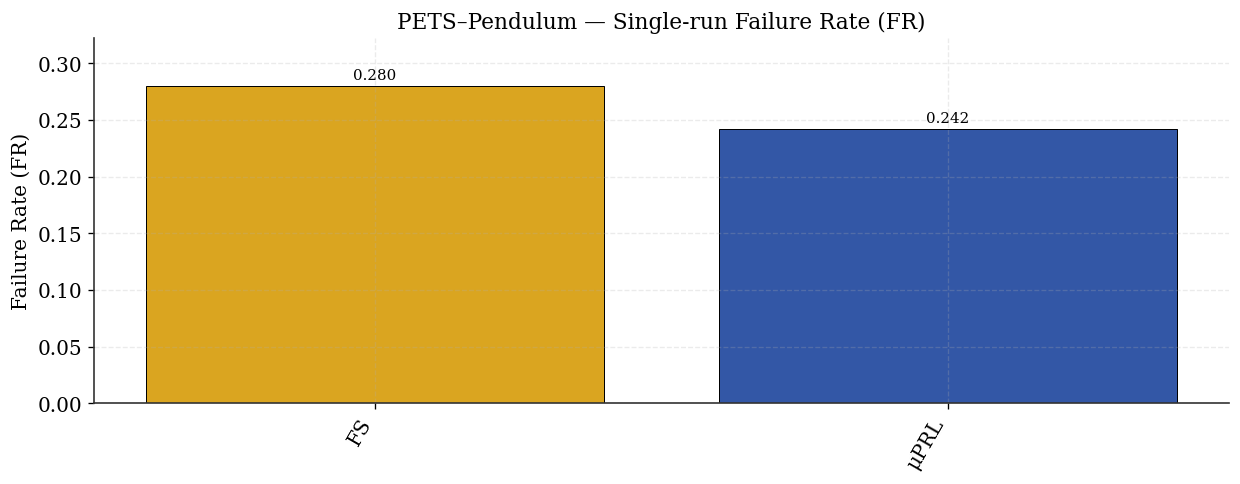

Saved: /content/drive/MyDrive/mbrl-testing-frameworks-empirical-study/results/pendulum/figs/pendulum_FR_single_all_fw


In [ ]:
# =========================================================
# FR bar chart (PETS + Pendulum, single-run)
# =========================================================

import numpy as np
import matplotlib.pyplot as plt

FIGS_DIR.mkdir(exist_ok=True)

plt.rcParams.update({
    "figure.figsize": (10.5, 4.2),
    "font.family": "serif",
    "font.serif": ["Times New Roman", "DejaVu Serif", "Nimbus Roman", "Times"],
    "font.size": 12,
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "axes.edgecolor": "#333",
    "axes.linewidth": 1.0,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "grid.linestyle": "--",
    "legend.frameon": False,
})

def plot_fr(df, title, out_base):
    d = df.copy().sort_values("framework")
    labels = d["framework"].tolist()
    y = pd.to_numeric(d["FR"], errors="coerce").fillna(0.0).to_numpy()
    x = np.arange(len(labels))
    colors = [fw_color(f) for f in labels]

    plt.figure()
    bars = plt.bar(x, y, color=colors, edgecolor="black", linewidth=0.6)

    ymax = max(0.05, float(np.nanmax(y)) * 1.15)
    plt.ylim(0, ymax)
    plt.xticks(x, labels, rotation=60, ha="right")
    plt.ylabel("Failure Rate (FR)")
    plt.title(title)
    plt.grid(True, axis="y", alpha=0.25, linestyle="--")
    plt.tight_layout()

    for b, m in zip(bars, y):
        plt.text(
            b.get_x() + b.get_width() / 2,
            b.get_height() + 0.01 * ymax,
            f"{m:.3f}",
            ha="center",
            va="bottom",
            fontsize=9,
        )

    for ext in (".png", ".pdf", ".svg"):
        try:
            plt.savefig(str(out_base) + ext, bbox_inches="tight")
        except Exception:
            pass

    plt.show()
    plt.close()
    print("Saved:", out_base)

plot_fr(
    SINGLE,
    "PETS–Pendulum — Single-run Failure Rate (FR)",
    FIGS_DIR / "pendulum_FR_single_all_fw",
)